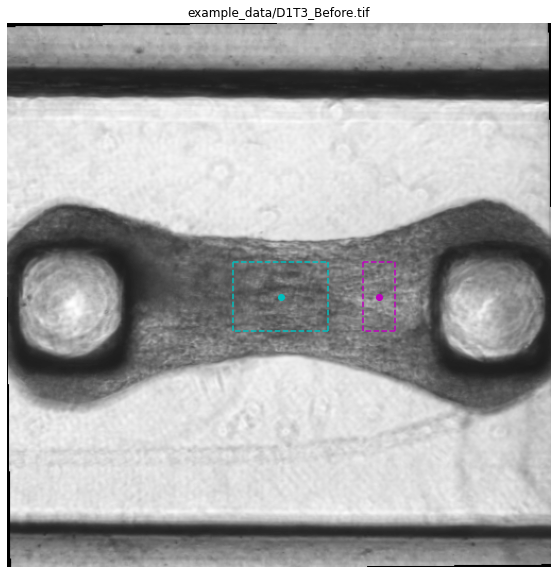

In [6]:
import matplotlib.pyplot as plt
from skimage import io

# import data and assign region properties 
example_fname = 'example_data/D1T3_Before.tif'
example_image = io.imread(example_fname)

center_x = 257
center_y = 257
center_w = 90
center_h = 65
edge_x = 350
edge_y = 257
edge_w = 30
edge_h = 65

plt.figure(figsize=(10,10))
plt.imshow(example_image[0,:,:],cmap=plt.cm.gray)
plt.plot(center_x,center_y,'co')
plt.plot(edge_x,edge_y,'mo')

coords_x = [center_x-center_w/2.0,center_x+center_w/2.0,center_x+center_w/2.0,center_x-center_w/2.0,center_x-center_w/2.0]
coords_y = [center_y-center_h/2.0,center_y-center_h/2.0,center_y+center_h/2.0,center_y+center_h/2.0,center_y-center_h/2.0]
for kk in range(0,4):
    plt.plot([coords_x[kk],coords_x[kk+1]],[coords_y[kk],coords_y[kk+1]],'c--')

coords_x = [edge_x-edge_w/2.0,edge_x+edge_w/2.0,edge_x+edge_w/2.0,edge_x-edge_w/2.0,edge_x-edge_w/2.0]
coords_y = [edge_y-edge_h/2.0,edge_y-edge_h/2.0,edge_y+edge_h/2.0,edge_y+edge_h/2.0,edge_y-edge_h/2.0]
for kk in range(0,4):
    plt.plot([coords_x[kk],coords_x[kk+1]],[coords_y[kk],coords_y[kk+1]],'m--')

plt.title(example_fname)
plt.axis('off')
plt.savefig('D1T3_Before_regions')

In [2]:
# compute the masks and prepare the image (processing the tif is slow)
import compute_strain_additional_functions as ssf 

image = example_image[0,:,:]
mask_center = ssf.define_mask(center_x,center_y,center_w,center_h,image)
mask_edge = ssf.define_mask(edge_x,edge_y,edge_w,edge_h,image)

mask = mask_center + mask_edge
input_tag = 'example_data/D1T3_Before'
tag = 'D1T3_Before'
ssf.process_tif_color_scale(input_tag,tag,mask)

50427 16177


In [3]:
import numpy as np

# identify the individual beats in the image 
frame_pairs = ssf.compute_frame_pairs(tag,mask)

# compute the strain during each beat for the center 
mask = mask_center
E_xx_all_center = []; E_yy_all_center = []; E_xy_all_center = [] 
E_xx_peak_center = []; E_yy_peak_center = []; E_xy_peak_center = []; peak_frame_center = [] 
for kk in range(0,len(frame_pairs)):
    frame_0 = frame_pairs[kk][0]
    block_size = frame_pairs[kk][1] - frame_pairs[kk][0]
    tracker_x, tracker_y = ssf.lk_block_track(tag,mask,frame_0,block_size)
    F_all, Exx_all, Eyy_all, Exy_all = ssf.compute_strain(tracker_x,tracker_y)
    E_xx_all_center.append(Exx_all)
    E_yy_all_center.append(Eyy_all)
    E_xy_all_center.append(Exy_all)
    # we are interested in keeping track of the maximum absolute strain in the xx (horizontal) direction 
    argmax = np.argmax(np.abs(Exx_all))
    E_xx_peak_center.append(Exx_all[argmax])
    E_yy_peak_center.append(Eyy_all[argmax])
    E_xy_peak_center.append(Exy_all[argmax])
    peak_frame_center.append(argmax)

# compute the strain during each beat for the edge 
mask = mask_edge
E_xx_all_edge = []; E_yy_all_edge = []; E_xy_all_edge = [] 
E_xx_peak_edge = []; E_yy_peak_edge = []; E_xy_peak_edge = []; peak_frame_edge = [] 
for kk in range(0,len(frame_pairs)):
    frame_0 = frame_pairs[kk][0]
    block_size = frame_pairs[kk][1] - frame_pairs[kk][0]
    tracker_x, tracker_y = ssf.lk_block_track(tag,mask,frame_0,block_size)
    F_all, Exx_all, Eyy_all, Exy_all = ssf.compute_strain(tracker_x,tracker_y)
    E_xx_all_edge.append(Exx_all)
    E_yy_all_edge.append(Eyy_all)
    E_xy_all_edge.append(Exy_all)
    # we are interested in keeping track of the maximum absolute strain in the xx (horizontal) direction 
    argmax = np.argmax(np.abs(Exx_all))
    E_xx_peak_edge.append(Exx_all[argmax])
    E_yy_peak_edge.append(Eyy_all[argmax])
    E_xy_peak_edge.append(Exy_all[argmax])
    peak_frame_edge.append(argmax)


# re-arrange lists for plotting 
Exx_center = [item for sublist in E_xx_all_center for item in sublist]
Eyy_center = [item for sublist in E_yy_all_center for item in sublist]
Exy_center = [item for sublist in E_xy_all_center for item in sublist]
Exx_edge = [item for sublist in E_xx_all_edge for item in sublist]
Eyy_edge = [item for sublist in E_yy_all_edge for item in sublist]
Exy_edge = [item for sublist in E_xy_all_edge for item in sublist]


------------------------------------------------
mean max Exx center: -0.019634637716389753
mean max Exx side:   -0.025208899359808117
------------------------------------------------


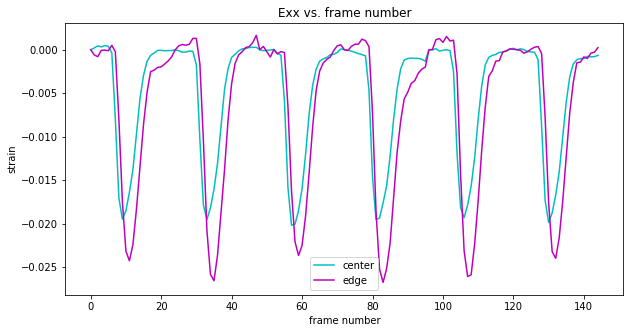

In [8]:
# visualize the results
plt.figure(figsize=(10,5))
plt.plot(Exx_center,'c-',label='center')
plt.plot(Exx_edge,'m-',label='edge')
plt.legend()
plt.title('Exx vs. frame number')
plt.xlabel('frame number')
plt.ylabel('strain')
plt.savefig('D1T3_Before_strain')

# print the average maximum contraction for each region (this is the number used the analysis in the paper)
print('------------------------------------------------')
print('mean max Exx center:',np.mean(E_xx_peak_center))
print('mean max Exx side:  ',np.mean(E_xx_peak_edge))
print('------------------------------------------------')
